In [23]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [24]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [25]:
NUM_CLASSES = 7

# Dataset reading

In [26]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [27]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [29]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [30]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_2 (Dropout)         (None, 42)                0         
                                                                 
 dense_3 (Dense)             (None, 20)                860       
                                                                 
 dropout_3 (Dropout)         (None, 20)                0         
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 dense_5 (Dense)             (None, 7)                 77        
                                                                 
Total params: 1,147
Trainable params: 1,147
Non-trainable params: 0
_________________________________________________________________


In [31]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [32]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [33]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/45 [..............................] - ETA: 14s - loss: 2.0095 - accuracy: 0.1641
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
45/45 [==============================] - 0s 3ms/step - loss: 1.9493 - accuracy: 0.1752 - val_loss: 1.9029 - val_accuracy: 0.3381
Epoch 2/1000
 1/45 [..............................] - ETA: 0s - loss: 1.9141 - accuracy: 0.2266
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
45/45 [==============================] - 0s 2ms/step - loss: 1.8832 - accuracy: 0.2536 - val_loss: 1.8022 - val_accuracy: 0.3339
Epoch 3/1000
 1/45 [..............................] - ETA: 0s - loss: 1.8619 - accuracy: 0.2891
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
45/45 [==============================] - 0s 2ms/step - loss: 1.8051 - accuracy: 0.2887 - val_loss: 1.6914 - val_accuracy: 0.3445
Epoch 4/1000
 1/45 [..............................] - ETA: 0s - loss: 1.7827 - accuracy: 0.2500


In [34]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

15/15 [==============================] - 0s 771us/step - loss: 0.8099 - accuracy: 0.7511


In [35]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [36]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 36ms/step
[1.53973065e-02 3.30272596e-03 9.07580435e-01 1.84929857e-04
 3.09807211e-02 3.53844501e-02 7.16959266e-03]
2


# Confusion matrix

59/59 [==============================] - 0s 529us/step


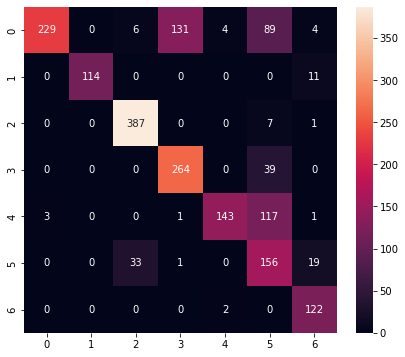

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.49      0.66       463
           1       1.00      0.91      0.95       125
           2       0.91      0.98      0.94       395
           3       0.66      0.87      0.75       303
           4       0.96      0.54      0.69       265
           5       0.38      0.75      0.51       209
           6       0.77      0.98      0.87       124

    accuracy                           0.75      1884
   macro avg       0.81      0.79      0.77      1884
weighted avg       0.83      0.75      0.75      1884



In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [38]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [39]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpyv3tlmmo/assets


INFO:tensorflow:Assets written to: /tmp/tmpyv3tlmmo/assets
2023-03-13 21:44:29.431832: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-03-13 21:44:29.431854: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-03-13 21:44:29.431986: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpyv3tlmmo
2023-03-13 21:44:29.433029: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-03-13 21:44:29.433045: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpyv3tlmmo
2023-03-13 21:44:29.437021: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-03-13 21:44:29.466347: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpyv3tlmmo
2023-03-13 21:44:29.473411: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

6704

# Inference test

In [40]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [41]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [42]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [43]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 877 µs, sys: 53 µs, total: 930 µs
Wall time: 1.4 ms


In [44]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.5397311e-02 3.3027285e-03 9.0758032e-01 1.8492999e-04 3.0980716e-02
 3.5384454e-02 7.1695950e-03]
2
